In [1]:
import tensorflow as tf
import numpy as np
from utils import read_labels, LabelEncoder, Object, Annotation, parse_annotation, draw_image, image_to_vgg_input

In [2]:
vgg = tf.keras.applications.VGG19()
vgg.summary()

W1207 23:42:24.113880 30816 deprecation.py:506] From C:\Users\Gencho\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
#input_tensor = tf.keras.Input(shape = (224, 224, 3))
vggobjdet = tf.keras.applications.VGG19(weights ='imagenet', include_top = False, input_shape=(224, 224, 3), pooling="avg")
#vgg = tf.keras.applications.VGG19()

vggobjdet.trainable = False
vggobjdet.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
labels_count = 0#20
grid_size = 7
boxes_per_grid_cell = 2

In [5]:
layers = vggobjdet.layers[:]
fc1 = tf.keras.layers.Dense(units = 4096, activation = "relu")

#finallayercount = grid_size * grid_size * (5 * boxes_per_grid_cell + labels_count)
finallayercount = grid_size * grid_size * (5 * boxes_per_grid_cell)

#object_detection_predictions_layer = tf.keras.layers.Dense(units = grid_size * grid_size * (5 * boxes_per_grid_cell + labels_count))
object_detection_predictions_layer = tf.keras.layers.Dense(units = finallayercount, activation = "sigmoid")

reshape = tf.keras.layers.Reshape(target_shape = (grid_size, grid_size, 5 * boxes_per_grid_cell + labels_count))


layers.append(fc1)
layers.append(object_detection_predictions_layer)
layers.append(reshape)
#layers.append(tf.keras.layers.Reshape(target_shape=(grid_size, grid_size, (5 * boxes_per_grid_cell + labels_count))))


model = tf.keras.Sequential(layers = layers, name = "object detector")
model.summary()

Model: "object detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)   

In [6]:
Lcoord = 5
Lnoobj = 0.5

![Output shape](outputshape.png)

In [7]:
def reshaped_custom_loss(y_true, y_pred):
    '''
        output:
        grid_size * grid_size * (5 * boxes_per_grid + labels)
        
    '''
    #TODO: implement conditions - maybe experiment with masks?
    
    loss = tf.constant(0.0)
    #print(tf.shape(y_pred))
    
    
    
    for row in range(grid_size):
        for col in range(grid_size):
            
            '''
                if(object in this cell):
                    classes[obj] = 1
                    best box (by IOU):
                        conf = 1
                        adjust x y w h
                    useless boxes:
                        conf = 0
                else:
                    conf = 0
                    classes = 0
            '''
                
            
            for box in range(boxes_per_grid_cell):
                               
                c_pred = y_pred[:, row, col, 5 * box]
                c_true = y_true[:, row, col, 5 * box]
                
                xy_pred = y_pred[:, row, col, 5 * box + 1 : 5 * box + 2]
                xy_true = y_true[:, row, col, 5 * box + 1 : 5 * box + 2]
                
                wh_pred = y_pred[:, row, col, 5 * box + 3 : 5 * box + 4]
                wh_true = y_true[:, row, col, 5 * box + 3 : 5 * box + 4]
                
                
                
                
                #x_pred = y_pred[:, row, col, 5 * box]
                #x_true = y_true[:, row, col, 5 * box]
                
                #print(c_true)
                #coef = 1 if c_true == 1 else Lnoobj
                
                coef = tf.constant(1.0)
                #coef = tf.cond(tf.equal(c_true, [1.0]), lambda: 1, lambda: Lnoobj)
                #print(coef)
                
                loss = tf.add(loss, coef * ((c_true - c_pred) ** 2))
                loss = tf.add(loss, coef * ((xy_true - xy_pred) ** 2))
                loss = tf.add(loss, coef * ((wh_true - wh_pred) ** 2))
                
    
    
    return loss

def custom_loss(y_true, y_pred):
    '''
    output tensor:
    
    for each cell:
        for each bounding box:
            x, y, w, h, C(any)
        for each class:
            C(class)
    
    flattened
    '''

    
    #TODO: translate every operation to tensorflow?
    
    loss = tf.constant(0.0)
    
    step_size = 5 * boxes_per_grid_cell + labels_count
    
    def get_true_pred(index):
        return y_true[:, index], y_pred[:, index]
    
    for cell in range(grid_size ** 2):
        index = cell * step_size # 0
        
        '''
        TODO:
        At training time we only want one bounding box predictor to be responsible for each object. 
        We assign one predictor to be “responsible” for predicting an object based on which 
        prediction has the highest current IOU with the ground truth.
        We optimise the x,y,w,h,c of that box with Lcoord factor and just c of the others with Lnoobj factor        
        For ci we optimise for every box
        '''        
    
        for box in range(boxes_per_grid_cell):
            inner_step_size = box * 5
            
            
            Canytrue, Canypred = get_true_pred(inner_step_size + index)
            xtrue, xpred = get_true_pred(inner_step_size + index + 1)
            ytrue, ypred = get_true_pred(inner_step_size + index + 2)
            wtrue, wpred = get_true_pred(inner_step_size + index + 3)
            htrue, hpred = get_true_pred(inner_step_size + index + 4)
            
            
            #I FCKING GIVE UP
            
            #loss = tf.add(loss, tf.cond(tf.equal(Canytrue, 0), lambda: Lnoobj, lambda: 0) * ((Canytrue - Canypred) ** 2)) 
            
            #PROBLEM: the if Canytrue == 0 always returns false
            loss = tf.add(loss, (Lnoobj if Canytrue == 0 else 1) * ((Canytrue - Canypred) ** 2)) 
            #loss = tf.add(loss, (Lnoobj if Canytrue == 0 else 1) * ((Canytrue - Canypred) ** 2)) 
            
            #coef = tf.cond(tf.less(Canytrue, 1), lambda: 1, lambda: 0)
            loss = tf.cond(tf.less(tf.reduce_mean(tf.subtract(1.0, Canytrue)), 0), lambda: tf.add(tf.add(loss, Lcoord * ((xtrue - xpred) ** 2 + (ytrue - ypred) ** 2)), Lcoord * ((tf.sqrt(wtrue) - tf.sqrt(wpred)) ** 2 + (tf.sqrt(htrue) - tf.sqrt(hpred)) ** 2)), lambda: loss)    
           # tf.add(tf.add(loss, Lcoord * ((xtrue - xpred) ** 2 + (ytrue - ypred) ** 2)), Lcoord * ((tf.sqrt(wtrue) - tf.sqrt(wpred)) ** 2 + (tf.sqrt(htrue) - tf.sqrt(hpred)) ** 2)),
            #loss = tf.cond(tf.equal(Canytrue, 1), lambda: tf.add(tf.add(loss, Lcoord * ((xtrue - xpred) ** 2 + (ytrue - ypred) ** 2)), Lcoord * ((tf.sqrt(wtrue) - tf.sqrt(wpred)) ** 2 + (tf.sqrt(htrue) - tf.sqrt(hpred)) ** 2)), lambda: loss)       
           # loss = tf.cond(
           #     tf.reduce_any(Canytrue, 1.), 
           #     lambda: tf.add(tf.add(loss, Lcoord * ((xtrue - xpred) ** 2 + (ytrue - ypred) ** 2)), Lcoord * ((tf.sqrt(wtrue) - tf.sqrt(wpred)) ** 2 + (tf.sqrt(htrue) - tf.sqrt(hpred)) ** 2)), 
           #     lambda: loss)    
            #if Canytrue:
            #    loss += Lcoord * ((xtrue - xpred) ** 2 + (ytrue - ypred) ** 2)
            #    loss += Lcoord * ((sqrt(wtrue) - sqrt(wpred)) ** 2 + (sqrt(htrue) - sqrt(hpred)) ** 2)
        
        #TODO: ?
        #for label in range(labels_count):
            #Clabeltrue, Clabelpred = get_true_pred(index + boxes_per_grid_cell * 5 + label)
            
            #loss = tf.add(loss, (Lnoobj if Clabeltrue == 0 else 1) * ((Clabeltrue - Clabelpred) ** 2)) 
                
    return loss

In [8]:
adam = tf.keras.optimizers.Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer = adam, loss = reshaped_custom_loss)

In [9]:
import xml.etree.ElementTree as ET
import os

path = '.\VOCdevkit\VOC2007\Annotations'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.xml' in file:
            files.append(os.path.join(r, file))

files = files[:500]
            
eltrees = [ET.parse(file) for file in files]

allnames = []
uniques = set()

for names in [names for names in [xml.findall('object/name') for xml in eltrees]]:
    for name in names:
            allnames.append(name)
            uniques.add(name.text)

print(len(files))
print(len(allnames))
labels = [n for n in uniques]

print(uniques)
print(len(uniques))

500
1572
{'motorbike', 'bird', 'pottedplant', 'aeroplane', 'chair', 'bus', 'sofa', 'car', 'tvmonitor', 'horse', 'boat', 'person', 'cat', 'dog', 'cow', 'sheep', 'bottle', 'diningtable', 'bicycle', 'train'}
20


In [10]:
#labels, labels_count = read_labels("labels.txt")
labels, labels_count

(['motorbike',
  'bird',
  'pottedplant',
  'aeroplane',
  'chair',
  'bus',
  'sofa',
  'car',
  'tvmonitor',
  'horse',
  'boat',
  'person',
  'cat',
  'dog',
  'cow',
  'sheep',
  'bottle',
  'diningtable',
  'bicycle',
  'train'],
 0)

In [11]:
encoder = LabelEncoder(labels)

testlabel = labels[3]
print(testlabel)
print(encoder.encode(testlabel))
print(encoder.decode(encoder.encode(testlabel)))

aeroplane
3
aeroplane


In [12]:
testannotation = r'.\\VOCdevkit\\VOC2007\\Annotations\\000019.xml'

parsedannotation = parse_annotation(testannotation)

print(parsedannotation.filename)
print(parsedannotation.imagewidth)
print(parsedannotation.imageheight)
for obj in parsedannotation.objects:
    print(obj)

000019.jpg
500
375
cat (0) (231, 88) (483, 256)
cat (0) (11, 113) (266, 259)


In [13]:
'''
notes:
    normalize bounding box width and height according to image width and height so that they fall between 0 and 1
    normalize x, y according to the box
'''

def get_expected_output_from_annotations(annotation_path):
    '''
    
    
    Each grid cell predicts B bounding boxes and confidence
    scores for those boxes. These confidence scores reflect how
    confident the model is that the box contains an object and
    also how accurate it thinks the box is that it predicts. Formally we define confidence as Pr(Object) ∗ IOUtruth
    pred . If no
    object exists in that cell, the confidence scores should be
    zero. Otherwise we want the confidence score to equal the
    intersection over union (IOU) between the predicted box
    and the ground truth.
    
    '''
    #TODO(maybe): Implement a confidence for each box instead of 0 -> IOU of the best box possible
    
    parsed = parse_annotation(annotation_path)
    
    expected = np.zeros(grid_size * grid_size * (5 * boxes_per_grid_cell + labels_count))
    
    rowstep = parsed.imageheight / grid_size
    colstep = parsed.imagewidth / grid_size
    
    grid = [[[] for i in range(grid_size)] for i in range(grid_size)]
    
    for obj in parsed.objects:
        try:
            obj.xmid = (obj.xmax + obj.xmin) / 2
            obj.ymid = (obj.ymax + obj.ymin) / 2
            obj.width = obj.xmax - obj.xmin
            obj.height = obj.ymax - obj.ymin

            row = int(obj.ymid / rowstep)
            col = int(obj.xmid / colstep)

            grid[row][col].append(obj)
        except:
            print(parsed.filename)
            print(obj)
    
    tensorindex = 0
    for row in range(grid_size):
        for col in range(grid_size):
            objects = grid[row][col]                     
            
            # calculate bounding boxes
            boxleftstart = col * colstep
            boxtopstart = row * rowstep
            
            for box in range(boxes_per_grid_cell):
                if len(objects) > box:
                    obj = objects[box]              
                          
                    expected[tensorindex] = 1 #confidence
                    expected[tensorindex + 1] = (obj.xmid - boxleftstart) / colstep # x regarding box left border scaled to box width
                    expected[tensorindex + 2] = (obj.ymid - boxtopstart) / rowstep # y regarding box top border scaled to box height              
                    expected[tensorindex + 3] = obj.width / parsed.imagewidth # width relative to image width
                    expected[tensorindex + 4] = obj.height / parsed.imageheight #height relative to image height
                    
                    
                tensorindex += 5
                
            # mark objects present in grid cell 
            # TODO: rework if there are more classes present than boxes
            #for obj in objects:
            #    expected[tensorindex + encoder.encode(obj.name)] = 1
            tensorindex += labels_count               
    
    
    return expected

def get_expected_output_from_annotations_reshaped(annotation_path):
    
    outputs = get_expected_output_from_annotations(annotation_path)
    
    return np.reshape(outputs, (grid_size, grid_size, 5 * boxes_per_grid_cell + labels_count))
    

with np.printoptions(threshold=np.inf):
    print(get_expected_output_from_annotations_reshaped(testannotation))
#get_expected_output_from_annotations(testannotation)

[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0. 

In [14]:
def decode_predictions(output, image_w, image_h, threshold):
    objects = []
    
    rowstep = image_h / grid_size
    colstep = image_w / grid_size
    
    accepted = 0
    rejected = 0
    
    tensorindex = 0
    for row in range(grid_size):
        for col in range(grid_size):
            
            # calculate bounding boxes
            boxleftstart = col * colstep
            boxtopstart = row * rowstep            
            
            for box in range(boxes_per_grid_cell):
                c = output[tensorindex]# = 1 #confidence
                xmid = (output[tensorindex + 1] * colstep) + boxleftstart# x = (obj.xmid - boxleftstart) / colstep # x regarding box left border scaled to box width
                ymid = (output[tensorindex + 2] * rowstep) + boxtopstart# = (obj.ymid - boxtopstart) / rowstep # y regarding box top border scaled to box height              
                w = output[tensorindex + 3] * image_w# = obj.width / parsed.imagewidth # width relative to image width
                h = output[tensorindex + 4] * image_h# = obj.height / parsed.imageheight #height relative to image height
                
                
                               
                if(c >= threshold):
                    accepted+=1
                    obj = Object()
                    obj.xmin = xmid - (w / 2)
                    obj.ymin = ymid - (h / 2)
                    obj.xmax = xmid + (w / 2)
                    obj.ymax = ymid + (h / 2)
                    obj.conf = c
                    #obj.name =  #TODO: decode class

                    objects.append(obj)                                              
                else:
                    rejected+=1
                    
                tensorindex += 5 
                
            tensorindex += labels_count   
    
    print(f'accepted: {accepted} rejected: {rejected}')
    return objects

def decode_predictions_reshaped(output, image_w, image_h, threshold) :
    flattened = output.flatten()
    
    return decode_predictions(flattened, image_w, image_h, threshold)

cat (0) (231, 88) (483, 256)
cat (0) (11, 113) (266, 259)


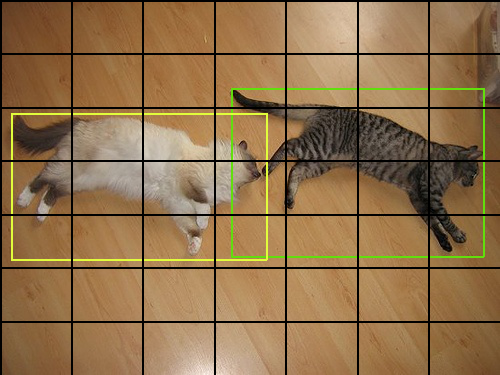

cat (0) (231, 88) (483, 256)
cat (0) (11, 113) (266, 259)


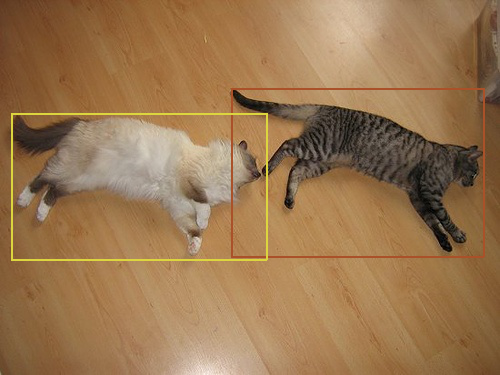

In [15]:
testimage = r'.\\VOCdevkit\\VOC2007\\JPEGImages\\000019.jpg'


draw_image(testimage, parsedannotation.objects, True, grid_size)
draw_image(testimage, parsedannotation.objects)

accepted: 2 rejected: 96
unnamed (1.0) (11.0, 113.0) (266.0, 259.0)
unnamed (1.0) (231.0, 88.0) (483.0, 256.0)
unnamed (1.0) (11.0, 113.0) (266.0, 259.0)
unnamed (1.0) (231.0, 88.0) (483.0, 256.0)


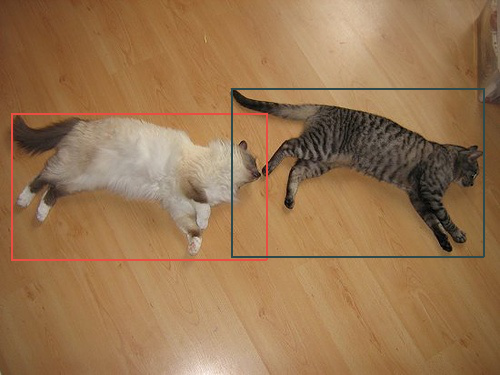

In [16]:
encoded = get_expected_output_from_annotations_reshaped(testannotation)

test_decode = decode_predictions_reshaped(encoded, parsedannotation.imagewidth, parsedannotation.imageheight, 0.1)

for obj in test_decode:
    print(obj)

draw_image(testimage, test_decode)

(1, 224, 224, 3)
accepted: 21 rejected: 77
unnamed (0.6272475719451904) (204.09655570983887, -48.24086065803256) (440.39082527160645, 103.77083186592374)
unnamed (0.6258488893508911) (335.15927621296476, -82.33563601970673) (592.3480434077127, 127.71664559841156)
unnamed (0.5827168822288513) (114.14140675749098, -24.676817868437084) (376.7676970788411, 178.8815898554666)
unnamed (0.6426972150802612) (286.3851870809283, -15.6902266400201) (506.66410582406183, 176.80990270205905)
unnamed (0.5632902383804321) (357.79869982174466, -44.33685913681984) (569.1279513495309, 192.4920491874218)
unnamed (0.5775986909866333) (227.7684903570584, 32.01520283307349) (419.669294995921, 230.7996584900788)
unnamed (0.558184802532196) (250.90288690158303, 32.88876318505831) (540.1292400700706, 236.92433589271135)
unnamed (0.5572139024734497) (311.1896578754697, 41.02754087320395) (597.0027808632169, 214.09176902047224)
unnamed (0.6355966925621033) (-108.30711254051754, 82.42545170443398) (162.74351945945

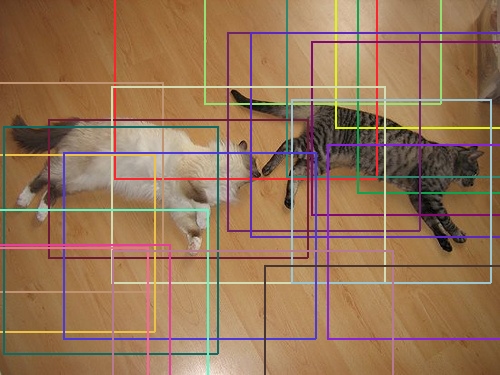

unnamed (1.0) (11.0, 113.0) (266.0, 259.0)
unnamed (1.0) (231.0, 88.0) (483.0, 256.0)


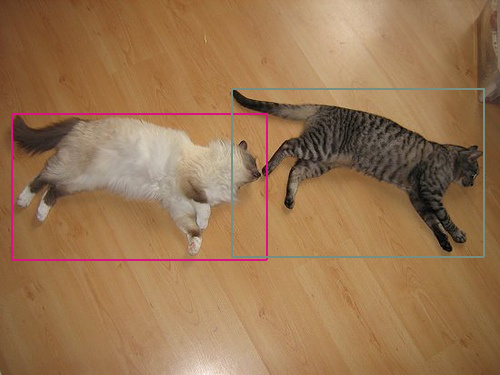

In [17]:
def image_to_nn_input(imagepath, inputshape):
    im = Img.open(imagepath).resize(inputshape)
    normalized = np.array(im) / 255
    
    return normalized

from utils import Img
def feed_forward(imagepath, threshold = 0.5):
    
    im = Img.open(imagepath)
    h = im.height
    w = im.width
    
    im = im.resize((224, 224))
    
    normalized = np.array(im) / 255
    normalized = np.array([normalized])
    print(normalized.shape)
    
    out = model.predict(normalized)[0]
    
    
    #decoded = decode_predictions(out, w, h, threshold)
    decoded = decode_predictions_reshaped(out, w, h, threshold)
    #for obj in decoded:
    #    print(obj)
    
    draw_image(imagepath, decoded)
    
feed_forward(testimage, 0.55)
draw_image(testimage, test_decode)
#for obj in test_decode:
#        print(obj)

In [18]:
imagesdir = r'.\\VOCdevkit\\VOC2007\\JPEGImages\\'
annonsdir = r'.\\VOCdevkit\\VOC2007\\Annotations\\'

#ims = np.array([image_to_nn_input(imagesdir + parse_annotation(annotation).filename, (224, 224)) for annotation in files])
ims = np.array([image_to_vgg_input(imagesdir + parse_annotation(annotation).filename, (224, 224)) for annotation in files])
outs = np.array([get_expected_output_from_annotations_reshaped(file) for file in files])

In [19]:
def train():  
    model.fit(x = ims, y = outs, epochs = 100)
    
def train_generator():
    
    print("prepared ims and outs")
    
    bs = 256
    epochs = 10
    #epochs = 1000    
    #gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
	#width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	#horizontal_flip=True, fill_mode="nearest")
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    h = model.fit_generator(gen.flow(ims, outs, batch_size = bs), steps_per_epoch = len(ims) // bs, epochs = epochs)
    return h
    
#train()
h = train_generator()

#model.compile(loss=custom_loss, optimizer=adam)
#model = tf.keras.models.load_model("./weights/kindagets000019.h5")

prepared ims and outs
Epoch 1/10


W1207 23:42:38.653599 30816 deprecation.py:323] From C:\Users\Gencho\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1/1 [==============================] - 22s 22s/step - loss: 100.0426
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 88.6319
Epoch 3/10
1/1 [==============================] - 1s 756ms/step - loss: 76.9949
Epoch 4/10
1/1 [==============================] - 1s 734ms/step - loss: 65.8287
Epoch 5/10
1/1 [==============================] - 1s 736ms/step - loss: 56.8174
Epoch 6/10
1/1 [==============================] - 1s 757ms/step - loss: 47.8220
Epoch 7/10
1/1 [==============================] - 1s 763ms/step - loss: 40.9205
Epoch 8/10
1/1 [==============================] - 1s 755ms/step - loss: 34.0379
Epoch 9/10
1/1 [==============================] - 1s 758ms/step - loss: 28.9082
Epoch 10/10
1/1 [==============================] - 1s 733ms/step - loss: 23.9162


(1, 224, 224, 3)
accepted: 11 rejected: 87
unnamed (0.5530091524124146) (216.85321309736798, -50.679534673690796) (416.9308213250978, 104.46560382843018)
unnamed (0.5451969504356384) (350.16621010644093, -81.50802286607879) (571.0609938417163, 126.62558523671967)
unnamed (0.5003623366355896) (131.80985727480478, -24.459871862615856) (353.33035566977094, 178.53828945330213)
unnamed (0.5799164772033691) (297.70213791302274, -15.900598040648873) (483.300690140043, 178.70779229061944)
unnamed (0.5079216957092285) (235.81229043858394, 32.640341137136716) (401.6495336379324, 230.08778265544345)
unnamed (0.5410556197166443) (-85.86183403219496, 84.46608909538816) (131.51097084794725, 287.96725400856565)
unnamed (0.6349177956581116) (-68.18909304482597, 157.21643849142959) (130.32137496130807, 330.58663963207175)
unnamed (0.5213213562965393) (78.14636826515198, 153.60889610435282) (289.9346053600311, 339.07702219273364)
unnamed (0.5119171738624573) (4.029516662870137, 206.30164816975594) (191.

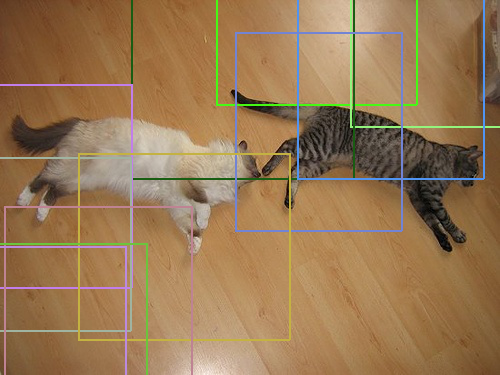

unnamed (1.0) (11.0, 113.0) (266.0, 259.0)
unnamed (1.0) (231.0, 88.0) (483.0, 256.0)


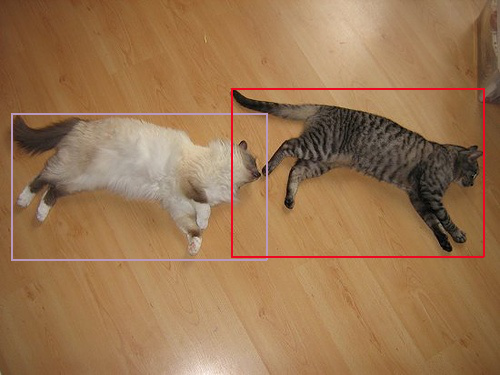

[[('n01817953', 'African_grey', 0.23581064), ('n02123045', 'tabby', 0.21954325), ('n03794056', 'mousetrap', 0.14921461), ('n02123159', 'tiger_cat', 0.10508165), ('n02124075', 'Egyptian_cat', 0.08914303)]]
[[('n02138441', 'meerkat', 0.41345188), ('n02137549', 'mongoose', 0.11507584), ('n02441942', 'weasel', 0.045278147), ('n03794056', 'mousetrap', 0.044022616), ('n01877812', 'wallaby', 0.04357954)]]


In [20]:
testxml = r'.\\VOCdevkit\\VOC2007\\Annotations\\000019.xml'
testimage = r'.\\VOCdevkit\\VOC2007\\JPEGImages\\000019.jpg'


feed_forward(testimage)
draw_image(testimage, test_decode)

#keras = tf.keras
#print(keras)

# keras way
image = tf.keras.preprocessing.image.load_img(testimage, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = tf.keras.applications.vgg19.preprocess_input(image)
#print(image)
preds = vgg.predict(image)
print(tf.keras.applications.vgg19.decode_predictions(preds))

# my way
im = Img.open(testimage).resize((224, 224))
im = np.array(im, np.float32)
im -= 255 / 2
#print(im)
preds = vgg.predict(np.array([im]))

print(tf.keras.applications.vgg19.decode_predictions(preds))

In [22]:
import matplotlib.pyplot as plt
history = h
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss'])


<Figure size 640x480 with 1 Axes>

In [23]:
#model.save("./weights/kindagets000019.h5")

In [26]:
'''
TODO urgent:
implement conditions in loss function

TODO not so urgent:
load original yolo weights
classification

TODO more long-term:
metrics
save/load weights & config (label encoding, etc.)
name conventions
'''

'\nTODO urgent:\nimplement conditions in loss function\n\nTODO not so urgent:\nload original yolo weights\nclassification\n\nTODO more long-term:\nmetrics\nsave/load weights & config (label encoding, etc.)\nname conventions\n'